## Importing Libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
from datetime import datetime
import joblib
import os

In [129]:
df = pd.read_csv('../data/raw/final_perfume_data.csv', encoding='ISO-8859-1')
df.head()

,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2191 non-null   object
 1   Brand        2191 non-null   object
 2   Description  2191 non-null   object
 3   Notes        2111 non-null   object
 4   Image URL    2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB


## Data Preprocessing

In [131]:
# Creating a new df for cleaning
cleaned_df = df.copy()

In [132]:
# Removing null values from the dataset
print(cleaned_df.isnull().sum())
cleaned_df.dropna(inplace=True)

Name            0
Brand           0
Description     0
Notes          80
Image URL       0
dtype: int64


In [133]:
# Removing the column for description and imageurl
cleaned_df.drop(columns=['Description', 'Image URL'], inplace=True)

In [134]:
# Lowering the column names and the values of the column
cleaned_df.columns = cleaned_df.columns.str.lower()
cleaned_df['name'] = cleaned_df['name'].str.lower()
cleaned_df['brand'] = cleaned_df['brand'].str.lower()
cleaned_df['notes'] = cleaned_df['notes'].str.lower()


In [135]:
# Removing the duplicate rows from the dataset
print(cleaned_df.duplicated().sum())

0


In [136]:
# Spliting the note values
cleaned_df['notes'] = cleaned_df['notes'].apply(lambda x: [note.strip() for note in x.split(',')])

In [137]:
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,"[vanilla bean, musks]"
1,sola parfum,di ser,"[lavender, yuzu, lemongrass, magnolia, geraniu..."
2,kagiroi parfum,di ser,"[green yuzu, green shikuwasa, sansho seed, cor..."
3,velvet fantasy eau de parfum,montale,"[tangerine, pink pepper, black coffee, leather..."
4,a blvd. called sunset eau de parfum,a lab on fire,"[bergamot, almond, violet, jasmine, leather, s..."


In [138]:
# Extract all notes into a single list
all_notes = [note for notes_list in cleaned_df['notes'] for note in notes_list]

# Get unique notes
unique_notes = set(all_notes)

# Print unique notes
for note in unique_notes:
    print(note)


violet leaf
absinth
indian rose absolut
lemongrass essential oil
crystalline musk
and cashmeran
tolu balsam and amber.
pink pepper berries
black tea
cypress root
italian iris absolute
bay laurel
vetiver java oil
himalayan rose
angelica root click here for ingredients ãclose neroli portofino by tom ford private blend ingredients please be aware that ingredient lists may change or vary from time to time.  please refer to the ingredient list on the product package you receive for the most up to date list of ingredients.
cocoa beans
brazilian palisander wood
cumin seed
rose from turkey
agar oud
sicilian broom flower
your guess is as good as ours.
taã¯f rose essential oil
indonesian ylang ylang
eau-de-vie
elemi oil
clear woods
angelica seeds
caledonian sandalwood
tonkin musk
palisander
blackcurrant bud absolute
scottish highland pine
mango
camomille from marocco
virginia cedarwood.
gurjun balsam
tolu balsam click here for ingredients ãclose rose prick by tom ford private blend ingredient

In [139]:
# Load the curated list of notes
with open("../data/cleaned_perfume_notes.txt", "r") as file:
    curated_notes = set(file.read().splitlines())

# Filter the notes in the dataframe
cleaned_df['notes'] = cleaned_df['notes'].apply(lambda notes_list: [note for note in notes_list if note in curated_notes])

# Display the cleaned dataframe
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,[musks]
1,sola parfum,di ser,"[lavender, yuzu, lemongrass, magnolia, geraniu..."
2,kagiroi parfum,di ser,"[coriander, shiso, rosewood, vetiver, hinoki, ..."
3,velvet fantasy eau de parfum,montale,"[tangerine, leather, violet, jasmine, vanilla,..."
4,a blvd. called sunset eau de parfum,a lab on fire,"[bergamot, almond, violet, jasmine, leather, s..."


In [140]:
# Convert list of notes to space-separated string
cleaned_df["notes"] = cleaned_df["notes"].apply(lambda x: " ".join(x))

In [141]:
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,musks
1,sola parfum,di ser,lavender yuzu lemongrass magnolia geranium jas...
2,kagiroi parfum,di ser,coriander shiso rosewood vetiver hinoki cyprio...
3,velvet fantasy eau de parfum,montale,tangerine leather violet jasmine vanilla amber...
4,a blvd. called sunset eau de parfum,a lab on fire,bergamot almond violet jasmine leather sandalw...


## Model Training

### Transforming Notes to TF-IDF

In [142]:
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X_notes = vectorizer.fit_transform(cleaned_df["notes"])

# Convert TF-IDF matrix to DataFrame
df_X_notes = pd.DataFrame(X_notes.toarray(), columns=vectorizer.get_feature_names_out(), index=cleaned_df["name"])

In [143]:
df_X_notes.head()

,absinth,absinthe,acacia,accord,agardwood,agarwood,agave,akigala,akigalawood,aldehyde,...,willow,wine,wisteria,wood,woods,woody,wool,wormwood,ylang,yuzu
name,,,,,,,,,,,,,,,,,,,,,
tihota eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
sola parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.42154
kagiroi parfum,0.0,0.0,0.0,0.0,0.0,0.36114,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
velvet fantasy eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
a blvd. called sunset eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


### Using elbow method to find the optimal cluster count

In [144]:
silhouette_scores = []
k_range = range(2, 15)

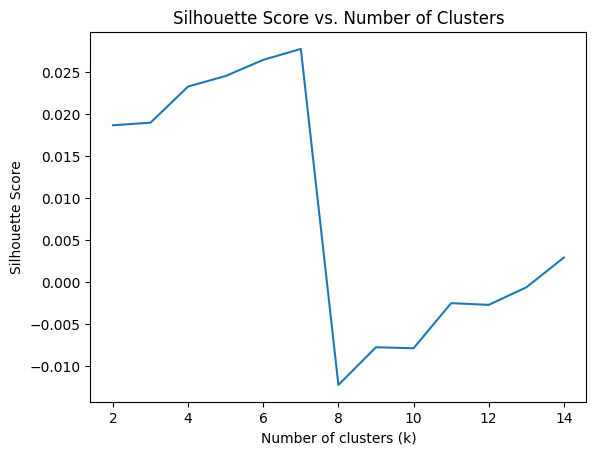

In [145]:
for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_notes)
        score = silhouette_score(X_notes, labels)
        silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette_score = round(np.max(silhouette_scores), 2)

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [146]:
# Train final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
final_kmeans.fit(X_notes)

KMeans(n_clusters=7, random_state=42)

In [147]:
# Exporting the model
# NAME: model_kmeans_k{clusters}_metric{score}_date{YYYYMMDD}.pkl

MODEL_DIR = "../models/rod"
current_date = datetime.now().strftime("%Y%m%d")
model_path = os.path.join(MODEL_DIR, f"model_kmeans_k{optimal_k}_metric{max_silhouette_score}_date{current_date}.pkl")

model_data = {
        'vectorizer': vectorizer,
        'kmeans': final_kmeans,
        'X_notes': X_notes,
        'optimal_k': optimal_k
    }

joblib.dump(model_data, model_path)

['../models/rod\\model_kmeans_k7_metric0.03_date20250217.pkl']

In [148]:
# Reduced dimension visualization using TruncatedSVD & Plotting
def visualization_clusters(model_data, n_components=2):
    # Convert sparse matrix to dense matrix
    X_notes_dense = model_data['X_notes'].toarray()
    
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_notes_dense)
    
    plotting_clusters(X_svd, df['Cluster'])

# Subfunction plotting clusters
def plotting_clusters(X_reduced, labels):    
    """Visualize clusters in 2D space."""
    df_plot = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2'])
    df_plot['Cluster'] = labels
    
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_plot, x='Dim1', y='Dim2', hue='Cluster', 
                    palette='viridis', s=60, alpha=0.8)
    plt.title("Perfume Clusters Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [149]:
# To give overview notes of each cluster
def get_cluster_terms(vectorizer, kmeans, n_terms=10):
    """Display top terms for each cluster."""
    terms = vectorizer.get_feature_names_out()
    for cluster_id in range(kmeans.n_clusters):
        centroid = kmeans.cluster_centers_[cluster_id]
        top_terms = terms[np.argsort(centroid)[-n_terms:][::-1]]
        print(f"Cluster {cluster_id} Top Terms: {', '.join(top_terms)}")

In [150]:
def recommend_perfumes(df, model_data, perfume_name, num_recs=5):
    """
    Get perfume recommendations based on scent similarity.
    
    Args:
        df: Preprocessed DataFrame
        model_data: Trained model artifacts
        perfume_name: Input perfume name
        num_recs: Number of recommendations to return
    
    Returns:
        DataFrame with recommendations or error message
    """
    # Normalize input
    perfume_name = perfume_name.lower().strip()
    
    # Fuzzy name matching
    if perfume_name not in df['Name'].values:
        matches = get_close_matches(perfume_name, df['Name'], n=1)
        if not matches:
            return f"No perfume found matching '{perfume_name}'"
        perfume_name = matches[0]
        print(f"Did you mean: '{perfume_name}'?")
    
    # Get perfume data
    perfume_data = df[df['Name'] == perfume_name]
    if perfume_data.empty:
        return f"Perfume '{perfume_name}' not found in database"
    
    idx = perfume_data.index[0]
    cluster = model_data['kmeans'].labels_[idx]
    
    # Get cluster members
    cluster_mask = (model_data['kmeans'].labels_ == cluster)
    cluster_df = df[cluster_mask].copy()
    cluster_df = cluster_df[cluster_df['Name'] != perfume_name]
    
    if cluster_df.empty:
        return f"No similar perfumes found in cluster {cluster}"
    
    # Calculate similarities
    similarities = cosine_similarity(
        model_data['X_notes'][idx],
        model_data['X_notes'][cluster_df.index]
    ).flatten()
    
    # Prepare results
    results = cluster_df.assign(Similarity=similarities)
    results = results.sort_values('Similarity', ascending=False)
    
    # Return top N with similarity scores
    return results[['Name', 'Brand', 'Notes', 'Similarity']].head(num_recs)

In [151]:
cleaned_df['Cluster'] = model_data['kmeans'].labels_

visualization_clusters(model_data['X_notes'], n_components=2)

get_cluster_terms(model_data['vectorizer'], model_data['kmeans'], n_terms=10)

recommend_perfumes(cleaned_df, model_data, "ormonde man eau de parfum")

IndexError: Index dimension must be 1 or 2